[Reference](https://sgino209.medium.com/deep-reinforcement-learning-for-automated-stock-trading-c661299ebe0f)

In [4]:
!pip install gymnasium
!pip install stable_baselines3

  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_curand_cu12-10.3.2.106-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cusolver_cu12-11.4.5.107-py3-none-manylinux1_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_cusparse_cu12-12.1.0.106-py3-none-manylinux1_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_nccl_cu12-2.20.5-py3-none-manylinux2014_x86_64.whl.metadata (1.8 kB)
  Using cached nvidia_nvtx_cu12-12.1.105-py3-none-manylinu

In [5]:
import numpy as np
import pandas as pd
import yfinance as yf
import gymnasium as gym
from gymnasium import spaces
import matplotlib.pyplot as plt
from stable_baselines3 import PPO, A2C, DDPG, SAC, TD3
from stable_baselines3.common.vec_env import DummyVecEnv
from stable_baselines3.common.callbacks import BaseCallback

# List of stocks in the Dow Jones 30
tickers = [
    'MMM', 'AXP', 'AAPL', 'BA', 'CAT', 'CVX', 'CSCO', 'KO', 'DIS', 'DOW',
    'GS', 'HD', 'IBM', 'INTC', 'JNJ', 'JPM', 'MCD', 'MRK', 'MSFT', 'NKE',
    'PFE', 'PG', 'TRV', 'UNH', 'UTX', 'VZ', 'V', 'WBA', 'WMT', 'XOM'
]
tickers.remove('DOW')
tickers.remove('UTX')

# Get historical data from Yahoo Finance and save it to dictionary
def fetch_stock_data(tickers, start_date, end_date):
    stock_data = {}
    for ticker in tickers:
        stock_data[ticker] = yf.download(ticker, start=start_date, end=end_date)
    return stock_data

# Call the function to get data
stock_data = fetch_stock_data(tickers, '2009-01-01', '2020-05-08')

[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%*******

- Training data shape for AAPL: (1762, 6)
- Validation data shape for AAPL: (252, 6)
- Test data shape for AAPL: (842, 6)



/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2009-01-02,3.067143,3.251429,3.041429,3.241071,2.737005,746015200
2009-01-05,3.327500,3.435000,3.311071,3.377857,2.852516,1181608400
2009-01-06,3.426786,3.470357,3.299643,3.322143,2.805469,1289310400
2009-01-07,3.278929,3.303571,3.223571,3.250357,2.744847,753048800
2009-01-08,3.229643,3.326786,3.215714,3.310714,2.795816,673500800


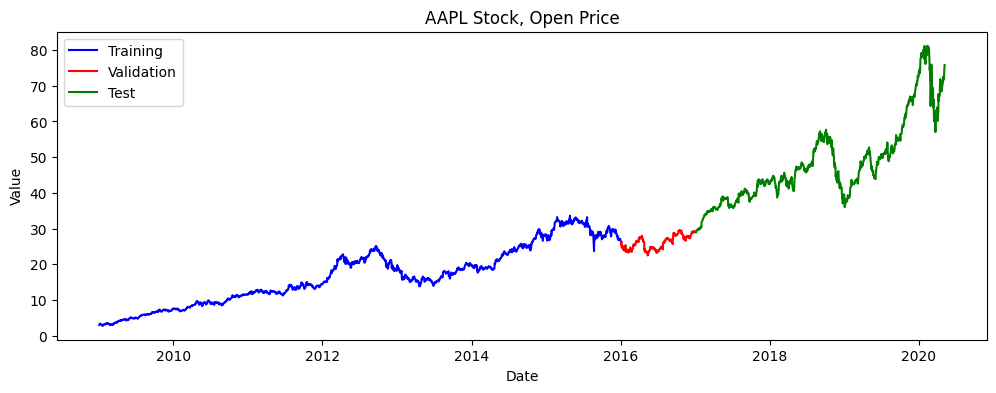

In [6]:
# split the data into training, validation and test sets
training_data_time_range = ('2009-01-01', '2015-12-31')
validation_data_time_range = ('2016-01-01', '2016-12-31')
test_data_time_range = ('2017-01-01', '2020-05-08')

# split the data into training, validation and test sets
training_data = {}
validation_data = {}
test_data = {}

for ticker, df in stock_data.items():
    training_data[ticker] = df.loc[training_data_time_range[0]:training_data_time_range[1]]
    validation_data[ticker] = df.loc[validation_data_time_range[0]:validation_data_time_range[1]]
    test_data[ticker] = df.loc[test_data_time_range[0]:test_data_time_range[1]]

# print shape of training, validation and test data
ticker = 'AAPL'
print(f'- Training data shape for {ticker}: {training_data[ticker].shape}')
print(f'- Validation data shape for {ticker}: {validation_data[ticker].shape}')
print(f'- Test data shape for {ticker}: {test_data[ticker].shape}\n')

# Display the first 5 rows of the data
display(stock_data['AAPL'].head())
print('\n')

# Plot:
plt.figure(figsize=(12, 4))
plt.plot(training_data[ticker].index, training_data[ticker]['Open'], label='Training', color='blue')
plt.plot(validation_data[ticker].index, validation_data[ticker]['Open'], label='Validation', color='red')
plt.plot(test_data[ticker].index, test_data[ticker]['Open'], label='Test', color='green')
plt.xlabel('Date')
plt.ylabel('Value')
plt.title(f'{ticker} Stock, Open Price')
plt.legend()
plt.show()

In [7]:
def add_technical_indicators(df):

    df = df.copy()

    # Calculate EMA 12 and 26 for MACD
    df.loc[:, 'EMA12'] = df['Close'].ewm(span=12, adjust=False).mean()
    df.loc[:, 'EMA26'] = df['Close'].ewm(span=26, adjust=False).mean()
    df.loc[:, 'MACD'] = df['EMA12'] - df['EMA26']
    df.loc[:, 'Signal'] = df['MACD'].ewm(span=9, adjust=False).mean()

    # Calculate RSI 14
    rsi_14_mode = True
    delta = df['Close'].diff()
    if rsi_14_mode:
        gain = (delta.where(delta > 0, 0)).rolling(window=14).mean()
        loss = (-delta.where(delta < 0, 0)).rolling(window=14).mean()
        rs = gain / loss
    else:
        up = delta.where(delta > 0, 0)
        down = -delta.where(delta < 0, 0)
        rs = up.rolling(window=14).mean() / down.rolling(window=14).mean()
    df.loc[:, 'RSI'] = 100 - (100 / (1 + rs))

    # Calculate CCI 20
    tp = (df['High'] + df['Low'] + df['Close']) / 3
    sma_tp = tp.rolling(window=20).mean()
    mean_dev = tp.rolling(window=20).apply(lambda x: np.mean(np.abs(x - x.mean())))
    df.loc[:, 'CCI'] = (tp - sma_tp) / (0.015 * mean_dev)

    # Calculate ADX 14
    high_diff = df['High'].diff()
    low_diff = df['Low'].diff()
    df.loc[:, '+DM'] = np.where((high_diff > low_diff) & (high_diff > 0), high_diff, 0)
    df.loc[:, '-DM'] = np.where((low_diff > high_diff) & (low_diff > 0), low_diff, 0)
    tr = pd.concat([df['High'] - df['Low'], np.abs(df['High'] - df['Close'].shift(1)), np.abs(df['Low'] - df['Close'].shift(1))], axis=1).max(axis=1)
    atr = tr.ewm(span=14, adjust=False).mean()
    df.loc[:, '+DI'] = 100 * (df['+DM'].ewm(span=14, adjust=False).mean() / atr)
    df.loc[:, '-DI'] = 100 * (df['-DM'].ewm(span=14, adjust=False).mean() / atr)
    dx = 100 * np.abs(df['+DI'] - df['-DI']) / (df['+DI'] + df['-DI'])
    df.loc[:, 'ADX'] = dx.ewm(span=14, adjust=False).mean()

    # Drop NaN values
    df.dropna(inplace=True)

    # Keep only the required columns
    df = df[['Open', 'High', 'Low', 'Close', 'Volume', 'MACD', 'Signal', 'RSI', 'CCI', 'ADX']]

    return df

# -----------------------------------------------------------------------------

# add technical indicators to the training data for each stock
for ticker, df in training_data.items():
    training_data[ticker] = add_technical_indicators(df)

# add technical indicators to the validation data for each stock
for ticker, df in validation_data.items():
    validation_data[ticker] = add_technical_indicators(df)

# add technical indicators to the test data for each stock
for ticker, df in test_data.items():
    test_data[ticker] = add_technical_indicators(df)

# print the first 5 rows of the data
print(f'- Training data shape for {ticker}: {training_data[ticker].shape}')
print(f'- Validation data shape for {ticker}: {validation_data[ticker].shape}')
print(f'- Test data shape for {ticker}: {test_data[ticker].shape}\n')

display(test_data[ticker].head())

- Training data shape for XOM: (1743, 10)
- Validation data shape for XOM: (233, 10)
- Test data shape for XOM: (823, 10)



,Open,High,Low,Close,Volume,MACD,Signal,RSI,CCI,ADX
Date,,,,,,,,,,
2017-01-31,85.040001,85.070000,83.129997,83.889999,19128100,-1.375811,-1.292896,39.171959,-127.861674,45.958728
2017-02-01,84.000000,84.160004,82.540001,82.940002,15111800,-1.484706,-1.331258,29.610121,-160.110316,43.789979
2017-02-02,83.209999,83.529999,82.550003,83.449997,12200100,-1.512420,-1.367491,34.837333,-153.801977,42.081047
2017-02-03,83.699997,83.720001,82.900002,83.540001,12746300,-1.509717,-1.395936,35.379803,-135.801428,44.498917
2017-02-06,83.550003,83.650002,82.930000,83.309998,9938200,-1.508743,-1.418497,27.066766,-129.114232,46.807713


In [8]:
class StockTradingEnv(gym.Env):

    metadata = {'render_modes': ['human']}

    # - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - -

    def __init__(self, stock_data, transaction_cost_percent=0.005):
        super(StockTradingEnv, self).__init__()
        """
        This function initializes the environment with stock data and sets up necessary variables:
        - Action and Observation Space: Defines the action space (buy/sell/hold) and
                                        observation space (stock prices, balance, shares held, net worth, etc.).
        - Account Variables: Initializes balance, net worth, shares held, and transaction costs.
        """

        # Remove any empty DataFrames
        self.stock_data = {ticker: df for ticker, df in stock_data.items() if not df.empty}
        self.tickers = list(self.stock_data.keys())

        if not self.tickers:
            raise ValueError("All provided stock data is empty")

        # Calculate the size of one stock's data
        sample_df = next(iter(self.stock_data.values()))
        self.n_features = len(sample_df.columns)

        # Define action and observation space
        self.action_space = spaces.Box(low=-1, high=1, shape=(len(self.tickers),), dtype=np.float32)

        # Observation space: price data for each stock + balance + shares held + net worth + max net worth + current step
        self.obs_shape = self.n_features * len(self.tickers) + 2 + len(self.tickers) + 2
        self.observation_space = spaces.Box(low=-np.inf, high=np.inf, shape=(self.obs_shape,), dtype=np.float32)

        # Initialize account balance
        self.initial_balance = 1000
        self.balance = self.initial_balance
        self.net_worth = self.initial_balance
        self.max_net_worth = self.initial_balance
        self.shares_held = {ticker: 0 for ticker in self.tickers}
        self.total_shares_sold = {ticker: 0 for ticker in self.tickers}
        self.total_sales_value = {ticker: 0 for ticker in self.tickers}

        # Set the current step
        self.current_step = 0

        # Calculate the minimum length of data across all stocks
        self.max_steps = max(0, min(len(df) for df in self.stock_data.values()) - 1)

        # Transaction cost
        self.transaction_cost_percent = transaction_cost_percent

    # - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - -

    def reset(self, seed=None, options=None):
        super().reset(seed=seed)
        """ Resets the environment to its initial state for a new episode. """

        # Reset the account balance
        self.balance = self.initial_balance
        self.net_worth = self.initial_balance
        self.max_net_worth = self.initial_balance
        self.shares_held = {ticker: 0 for ticker in self.tickers}
        self.total_shares_sold = {ticker: 0 for ticker in self.tickers}
        self.total_sales_value = {ticker: 0 for ticker in self.tickers}
        self.current_step = 0
        return self._next_observation(), {}

    # - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - -

    def _next_observation(self):
        """ Returns the current state of the environment, including stock prices, balance, shares held, net worth, etc. """

        # initialize the frame
        frame = np.zeros(self.obs_shape)

        # Add stock data for each ticker
        idx = 0
        # Loop through each ticker
        for ticker in self.tickers:
            # Get the DataFrame for the current ticker
            df = self.stock_data[ticker]
            # If the current step is less than the length of the DataFrame, add the price data for the current step
            if self.current_step < len(df):
                frame[idx:idx+self.n_features] = df.iloc[self.current_step].values
            # Otherwise, add the last price data available
            elif len(df) > 0:
                frame[idx:idx+self.n_features] = df.iloc[-1].values
            # Move the index to the next ticker
            idx += self.n_features

        # Add balance, shares held, net worth, max net worth, and current step
        frame[-4-len(self.tickers)] = self.balance # Balance
        frame[-3-len(self.tickers):-3] = [self.shares_held[ticker] for ticker in self.tickers] # Shares held
        frame[-3] = self.net_worth # Net worth
        frame[-2] = self.max_net_worth # Max net worth
        frame[-1] = self.current_step # Current step

        return frame

    # - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - -

    def step(self, actions):
        """ Executes an action in the environment, updates the state, calculates rewards, and checks if the episode is done. """

        # update the current step
        self.current_step += 1

        # check if we have reached the maximum number of steps
        if self.current_step > self.max_steps:
            return self._next_observation(), 0, True, False, {}

        current_prices = {}
        # Loop through each ticker and perform the action
        for i, ticker in enumerate(self.tickers):
            # Get the current price of the stock
            current_prices[ticker] = self.stock_data[ticker].iloc[self.current_step]['Close']
            # get the action for the current ticker
            action = actions[i]

            if action > 0:  # Buy
                # Calculate the number of shares to buy
                shares_to_buy = int(self.balance * action / current_prices[ticker])
                # Calculate the cost of the shares
                cost = shares_to_buy * current_prices[ticker]
                # Transaction cost
                transaction_cost = cost * self.transaction_cost_percent
                # Update the balance and shares held
                self.balance -= (cost + transaction_cost)
                # Update the total shares sold
                self.shares_held[ticker] += shares_to_buy

            elif action < 0:  # Sell
                # Calculate the number of shares to sell
                shares_to_sell = int(self.shares_held[ticker] * abs(action))
                # Calculate the sale value
                sale = shares_to_sell * current_prices[ticker]
                # Transaction cost
                transaction_cost = sale * self.transaction_cost_percent
                # Update the balance and shares held
                self.balance += (sale - transaction_cost)
                # Update the total shares sold
                self.shares_held[ticker] -= shares_to_sell
                # Update the shares sold
                self.total_shares_sold[ticker] += shares_to_sell
                # Update the total sales value
                self.total_sales_value[ticker] += sale

        # Calculate the net worth
        self.net_worth = self.balance + sum(self.shares_held[ticker] * current_prices[ticker] for ticker in self.tickers)

        # Update the max net worth
        self.max_net_worth = max(self.net_worth, self.max_net_worth)

        # Calculate the reward
        reward = self.net_worth - self.initial_balance

        # Check if the episode is done
        done = self.net_worth <= 0 or self.current_step >= self.max_steps

        obs = self._next_observation()
        return obs, reward, done, False, {}

    # - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - -

    def render(self, mode='human'):
        """ Displays the current state of the environment in a human-readable format. """

        # Print the current step, balance, shares held, net worth, and profit
        profit = self.net_worth - self.initial_balance
        print(f'Step: {self.current_step}')
        print(f'Balance: {self.balance:.2f}')
        for ticker in self.tickers:
            print(f'{ticker} Shares held: {self.shares_held[ticker]}')
        print(f'Net worth: {self.net_worth:.2f}')
        print(f'Profit: {profit:.2f}')

    def close(self):
        """ Placeholder for any cleanup operations """
        pass

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [9]:
class PolicyGradientLossCallback(BaseCallback):
    """
    A custom callback class that logs the policy_gradient_loss during training.
    This class extends BaseCallback and used to capture and store the metrics we want.
    """

    def __init__(self, verbose=0):
        super(PolicyGradientLossCallback, self).__init__(verbose)
        self.losses = []

    def _on_step(self) -> bool:
        if hasattr(self.model, 'logger'):
            logs = self.model.logger.name_to_value
            if 'train/policy_gradient_loss' in logs:
                loss = logs['train/policy_gradient_loss']
                self.losses.append(loss)
        return True

    def _on_training_end(self):
        """ Plot the loss after training ends """
        name = self.model.__class__.__name__
        plt.figure(figsize=(12, 4))
        plt.plot(self.losses, label='Policy Gradient Loss')
        plt.title(f'{name} - Policy Gradient Loss During Training')
        plt.xlabel('Training Steps')
        plt.ylabel('Loss')
        plt.legend()
        plt.show()

In [10]:
# Define PPO Agent
class PPOAgent:

    def __init__(self, env, total_timesteps, threshold):
        self.model = PPO("MlpPolicy", env, verbose=1)
        self.callback = PolicyGradientLossCallback()
        self.model.learn(total_timesteps=total_timesteps, callback=self.callback)
        self.threshold = threshold

    # - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - -

    def predict(self, obs):
        action, _ = self.model.predict(obs, deterministic=True)
        return action

    # - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - -

    def action_to_recommendation(self, action):
        recommendations = []
        for a in action:
            if a > self.threshold:
                recommendations.append('buy')
            elif a < -self.threshold:
                recommendations.append('sell')
            else:
                recommendations.append('hold')
        return recommendations

    # - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - -

    def validate(self, env):
        obs = env.reset()
        total_rewards = 0
        for _ in range(1000):  # Adjust based on needs
            action, _ = self.model.predict(obs)
            obs, reward, done, _ = env.step(action)
            total_rewards += reward
            if done:
                obs = env.reset()
        print(f'Agent Validation Reward: {total_rewards}')

# -----------------------------------------------------------------------------

# Define A2C Agent
class A2CAgent(PPOAgent):
    def __init__(self, env, total_timesteps, threshold):
        super().__init__(env, total_timesteps, threshold)
        self.model = A2C("MlpPolicy", env, verbose=1)
        self.callback = PolicyGradientLossCallback()
        self.model.learn(total_timesteps=total_timesteps, callback=self.callback)

# -----------------------------------------------------------------------------

# Define DDPG Agent
class DDPGAgent(PPOAgent):
    def __init__(self, env, total_timesteps, threshold):
        super().__init__(env, total_timesteps, threshold)
        self.model = DDPG("MlpPolicy", env, verbose=1)
        self.callback = PolicyGradientLossCallback()
        self.model.learn(total_timesteps=total_timesteps, callback=self.callback)

# -----------------------------------------------------------------------------

# Define SAC Agent
class SACAgent(PPOAgent):
    def __init__(self, env, total_timesteps, threshold):
        super().__init__(env, total_timesteps, threshold)
        self.model = SAC("MlpPolicy", env, verbose=1)
        self.callback = PolicyGradientLossCallback()
        self.model.learn(total_timesteps=total_timesteps, callback=self.callback)

# -----------------------------------------------------------------------------

# Define TD3 Agent
class TD3Agent(PPOAgent):
    def __init__(self, env, total_timesteps, threshold):
        super().__init__(env, total_timesteps, threshold)
        self.model = TD3("MlpPolicy", env, verbose=1)
        self.callback = PolicyGradientLossCallback()
        self.model.learn(total_timesteps=total_timesteps, callback=self.callback)

# -----------------------------------------------------------------------------

# Define Ensemble Agent
class EnsembleAgent:

    def __init__(self, ppo_model, a2c_model, ddpg_model, sac_model, td3_model, threshold):
        self.ppo_model = ppo_model
        self.a2c_model = a2c_model
        self.ddpg_model = ddpg_model
        self.sac_model = sac_model
        self.td3_model = td3_model
        self.threshold = threshold

    # - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - -

    def predict(self, obs):
        ppo_action, _ = self.ppo_model.predict(obs, deterministic=True)
        a2c_action, _ = self.a2c_model.predict(obs, deterministic=True)
        ddpg_action, _ = self.ddpg_model.predict(obs, deterministic=True)
        sac_action, _ = self.sac_model.predict(obs, deterministic=True)
        td3_action, _ = self.td3_model.predict(obs, deterministic=True)

        # Average the actions
        ensemble_action = np.mean([ppo_action, a2c_action, ddpg_action, sac_action, td3_action], axis=0)
        return ensemble_action

    # - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - -

    def action_to_recommendation(self, action):
        recommendations = []
        for a in action:
            if a > self.threshold:
                recommendations.append('buy')
            elif a < -self.threshold:
                recommendations.append('sell')
            else:
                recommendations.append('hold')
        return recommendations

    # - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - -

    def validate(self, env):
        obs = env.reset()
        total_rewards = 0
        for _ in range(1000):  # Adjust based on needs
            action = self.predict(obs)
            obs, reward, done, _ = env.step(action)
            total_rewards += reward
            if done:
                obs = env.reset()
        print(f'Agent Validation Reward: {total_rewards}')

In [11]:
# Function to create the environment and train the agents
def create_env_and_train_agents(train_data, val_data, total_timesteps, threshold):

    # Create environments for training and validation
    train_env = DummyVecEnv([lambda: StockTradingEnv(train_data)])
    val_env = DummyVecEnv([lambda: StockTradingEnv(val_data)])

    # Train and Validate PPO Agent
    ppo_agent = PPOAgent(train_env, total_timesteps, threshold)
    ppo_agent.validate(val_env)

    # Train and Validate A2C Agent
    a2c_agent = A2CAgent(train_env, total_timesteps, threshold)
    a2c_agent.validate(val_env)

    # Train and Validate DDPG Agent
    ddpg_agent = DDPGAgent(train_env, total_timesteps, threshold)
    ddpg_agent.validate(val_env)

    # Train and Validate SAC Agent
    sac_agent = SACAgent(train_env, total_timesteps, threshold)
    sac_agent.validate(val_env)

    # Train and Validate TD3 Agent
    td3_agent = TD3Agent(train_env, total_timesteps, threshold)
    td3_agent.validate(val_env)

    # Train and Validate the ensemble agent
    ensemble_agent = EnsembleAgent(ppo_agent.model, a2c_agent.model, ddpg_agent.model,
                                   sac_agent.model, td3_agent.model, threshold)
    ensemble_agent.validate(val_env)

    return train_env, val_env, ppo_agent, a2c_agent, ddpg_agent, sac_agent, td3_agent, ensemble_agent

# -----------------------------------------------------------------------------

# Function to visualize portfolio changes
def visualize_portfolio(steps, balances, net_worths, shares_held, tickers,
                        show_balance=True, show_net_worth=True, show_shares_held=True):

    fig, axs = plt.subplots(3, figsize=(12, 18))

    # Plot the balance
    if show_balance:
        axs[0].plot(steps, balances, label='Balance')
        axs[0].set_title('Balance Over Time')
        axs[0].set_xlabel('Steps')
        axs[0].set_ylabel('Balance')
        axs[0].legend()

    # Plot the net worth
    if show_net_worth:
        axs[1].plot(steps, net_worths, label='Net Worth', color='orange')
        axs[1].set_title('Net Worth Over Time')
        axs[1].set_xlabel('Steps')
        axs[1].set_ylabel('Net Worth')
        axs[1].legend()

    # Plot the shares held
    if show_shares_held:
        for ticker in tickers:
            axs[2].plot(steps, shares_held[ticker], label=f'Shares Held: {ticker}')
        axs[2].set_title('Shares Held Over Time')
        axs[2].set_xlabel('Steps')
        axs[2].set_ylabel('Shares Held')
        axs[2].legend()

    plt.tight_layout()
    plt.show()

# -----------------------------------------------------------------------------

# function to visualize the portfolio net worth
def visualize_portfolio_net_worth(steps, net_worths):

    plt.figure(figsize=(12, 6))
    plt.plot(steps, net_worths, label='Net Worth', color='orange')
    plt.title('Net Worth Over Time')
    plt.xlabel('Steps')
    plt.ylabel('Net Worth')
    plt.legend()
    plt.show()

# -----------------------------------------------------------------------------

# function to visualize the multiple portfolio net worths ( same chart )
def visualize_multiple_portfolio_net_worth(steps, net_worths_list, labels):

    plt.figure(figsize=(12, 6))
    for i, net_worths in enumerate(net_worths_list):
        plt.plot(steps, net_worths, label=labels[i])
    plt.title('Net Worth Over Time')
    plt.xlabel('Steps')
    plt.ylabel('Net Worth')
    plt.legend()
    plt.show()

# -----------------------------------------------------------------------------

def test_agent(env, agent, stock_data, n_tests=1000, visualize=False):
    """ Test a single agent and track performance metrics, with an option to visualize the results """

    # Initialize metrics tracking
    metrics = {
        'steps': [],
        'balances': [],
        'net_worths': [],
        'shares_held': {ticker: [] for ticker in stock_data.keys()}
    }

    # Reset the environment before starting the tests
    obs = env.reset()

    for i in range(n_tests):

        metrics['steps'].append(i)

        action = agent.predict(obs)

        obs, rewards, dones, infos = env.step(action)

        if visualize:
            env.render()

        # Track metrics
        metrics['balances'].append(env.get_attr('balance')[0])
        metrics['net_worths'].append(env.get_attr('net_worth')[0])
        env_shares_held = env.get_attr('shares_held')[0]

        # Update shares held for each ticker
        for ticker in stock_data.keys():
            if ticker in env_shares_held:
                metrics['shares_held'][ticker].append(env_shares_held[ticker])
            else:
                metrics['shares_held'][ticker].append(0)  # Append 0 if ticker is not found

        if dones:
            obs = env.reset()

    return metrics

# -----------------------------------------------------------------------------

def test_and_visualize_agents(env, agents, data, n_tests=1000):

    metrics = {}
    for agent_name, agent in agents.items():
        print(f"Testing {agent_name}...")
        metrics[agent_name] = test_agent(env, agent, data, n_tests=n_tests, visualize=True)

    # Extract net worths for visualization
    net_worths = [metrics[agent_name]['net_worths'] for agent_name in agents.keys()]
    steps = next(iter(metrics.values()))['steps']  # Assuming all agents have the same step count for simplicity

    # Visualize the performance metrics of multiple agents
    visualize_multiple_portfolio_net_worth(steps, net_worths, list(agents.keys()))

# -----------------------------------------------------------------------------

def compare_and_plot_agents(agents_metrics, labels, risk_free_rate=0.0):

    # Function to compare returns, standard deviation, and sharpe ratio of agents
    def compare_agents(agents_metrics, labels):
        returns = []
        stds = []
        sharpe_ratios = []

        for metrics in agents_metrics:

            net_worths = metrics['net_worths']

            # Calculate daily returns
            daily_returns = np.diff(net_worths) / net_worths[:-1]
            avg_return = np.mean(daily_returns)
            std_return = np.std(daily_returns)
            sharpe_ratio = ((avg_return - risk_free_rate) / std_return) if std_return != 0 else 'Inf'

            returns.append(avg_return)
            stds.append(std_return)
            sharpe_ratios.append(sharpe_ratio)

        df = pd.DataFrame({
            'Agent': labels,
            'Return': returns,
            'Standard Deviation': stds,
            'Sharpe Ratio': sharpe_ratios
        })

        return df

    # Compare agents
    df = compare_agents(agents_metrics, labels)

    # Sort the dataframe by sharpe ratio
    df_sorted = df.sort_values(by='Sharpe Ratio', ascending=False)

    # Display the dataframe
    display(df_sorted)

    # Plot bar chart for sharpe ratio
    plt.figure(figsize=(12, 6))
    plt.bar(df_sorted['Agent'], df_sorted['Sharpe Ratio'])
    plt.title('Sharpe Ratio Comparison')
    plt.xlabel('Agent')
    plt.ylabel('Sharpe Ratio')
    plt.show()

Using cpu device
-----------------------------
| time/              |      |
|    fps             | 159  |
|    iterations      | 1    |
|    time_elapsed    | 12   |
|    total_timesteps | 2048 |
-----------------------------
-----------------------------------------
| time/                   |             |
|    fps                  | 150         |
|    iterations           | 2           |
|    time_elapsed         | 27          |
|    total_timesteps      | 4096        |
| train/                  |             |
|    approx_kl            | 0.005779173 |
|    clip_fraction        | 0.0265      |
|    clip_range           | 0.2         |
|    entropy_loss         | -39.7       |
|    explained_variance   | -1.14e-05   |
|    learning_rate        | 0.0003      |
|    loss                 | 5.34e+07    |
|    n_updates            | 10          |
|    policy_gradient_loss | -0.00973    |
|    std                  | 1           |
|    value_loss           | 9.93e+07    |
-----------------

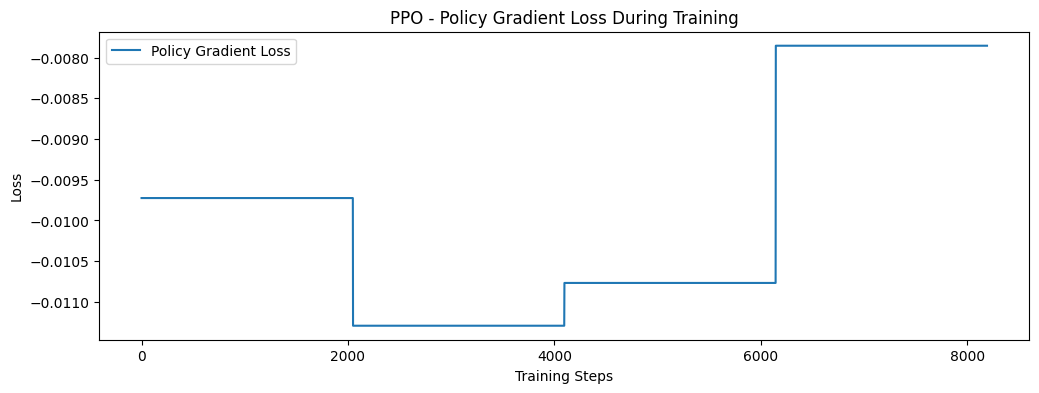

Agent Validation Reward: [-110453.97]
Using cpu device
-----------------------------
| time/              |      |
|    fps             | 161  |
|    iterations      | 1    |
|    time_elapsed    | 12   |
|    total_timesteps | 2048 |
-----------------------------
------------------------------------------
| time/                   |              |
|    fps                  | 152          |
|    iterations           | 2            |
|    time_elapsed         | 26           |
|    total_timesteps      | 4096         |
| train/                  |              |
|    approx_kl            | 0.0059729107 |
|    clip_fraction        | 0.0275       |
|    clip_range           | 0.2          |
|    entropy_loss         | -39.7        |
|    explained_variance   | 1.22e-05     |
|    learning_rate        | 0.0003       |
|    loss                 | 4.74e+07     |
|    n_updates            | 10           |
|    policy_gradient_loss | -0.00853     |
|    std                  | 1            |
|   

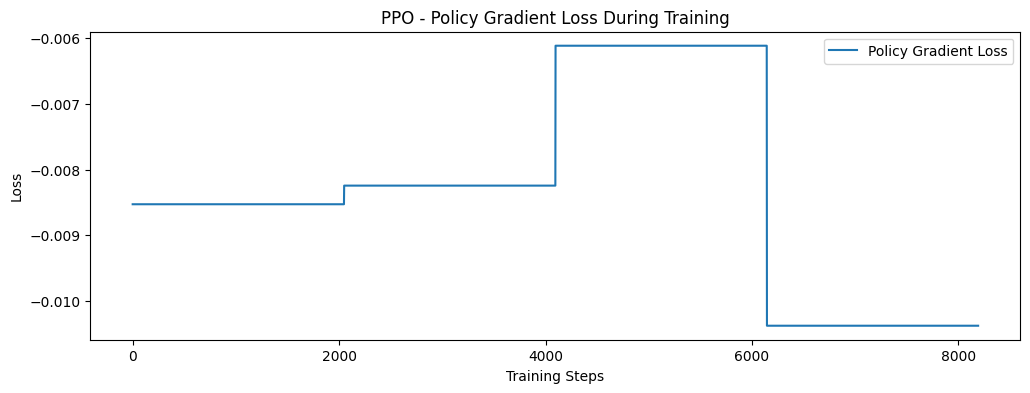

Using cpu device
------------------------------------
| time/                 |          |
|    fps                | 151      |
|    iterations         | 100      |
|    time_elapsed       | 3        |
|    total_timesteps    | 500      |
| train/                |          |
|    entropy_loss       | -40      |
|    explained_variance | 0.000979 |
|    learning_rate      | 0.0007   |
|    n_updates          | 99       |
|    policy_loss        | -5.5e+04 |
|    std                | 1.01     |
|    value_loss         | 2.27e+06 |
------------------------------------
-------------------------------------
| time/                 |           |
|    fps                | 132       |
|    iterations         | 200       |
|    time_elapsed       | 7         |
|    total_timesteps    | 1000      |
| train/                |           |
|    entropy_loss       | -40       |
|    explained_variance | -1.61e-05 |
|    learning_rate      | 0.0007    |
|    n_updates          | 199       |
|    polic

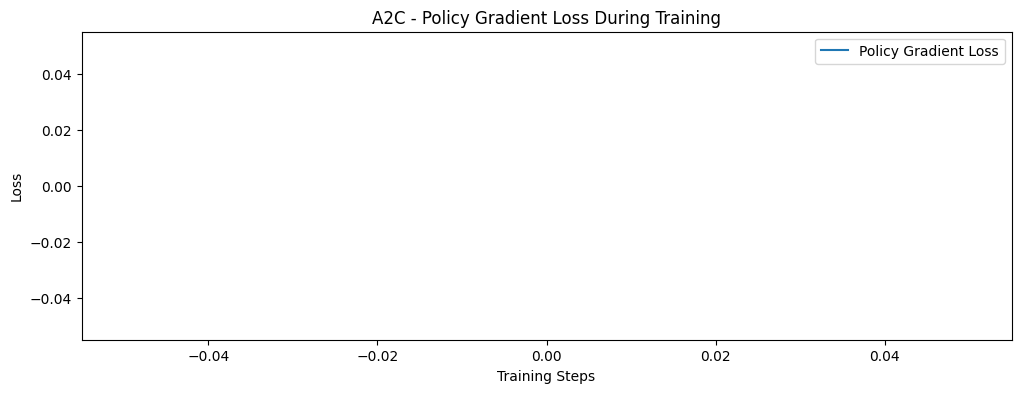

Agent Validation Reward: [103974.64]
Using cpu device
-----------------------------
| time/              |      |
|    fps             | 159  |
|    iterations      | 1    |
|    time_elapsed    | 12   |
|    total_timesteps | 2048 |
-----------------------------
-----------------------------------------
| time/                   |             |
|    fps                  | 151         |
|    iterations           | 2           |
|    time_elapsed         | 26          |
|    total_timesteps      | 4096        |
| train/                  |             |
|    approx_kl            | 0.007604927 |
|    clip_fraction        | 0.0587      |
|    clip_range           | 0.2         |
|    entropy_loss         | -39.7       |
|    explained_variance   | -1.91e-06   |
|    learning_rate        | 0.0003      |
|    loss                 | 5.96e+07    |
|    n_updates            | 10          |
|    policy_gradient_loss | -0.0121     |
|    std                  | 1           |
|    value_loss       

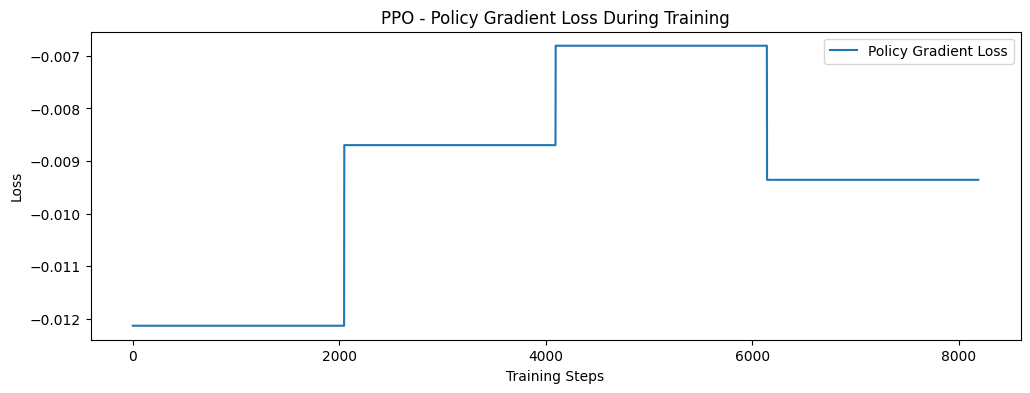

Using cpu device
----------------------------------
| time/              |           |
|    episodes        | 4         |
|    fps             | 21        |
|    time_elapsed    | 327       |
|    total_timesteps | 6968      |
| train/             |           |
|    actor_loss      | -9.68e+04 |
|    critic_loss     | 3.93e+08  |
|    learning_rate   | 0.001     |
|    n_updates       | 6867      |
----------------------------------


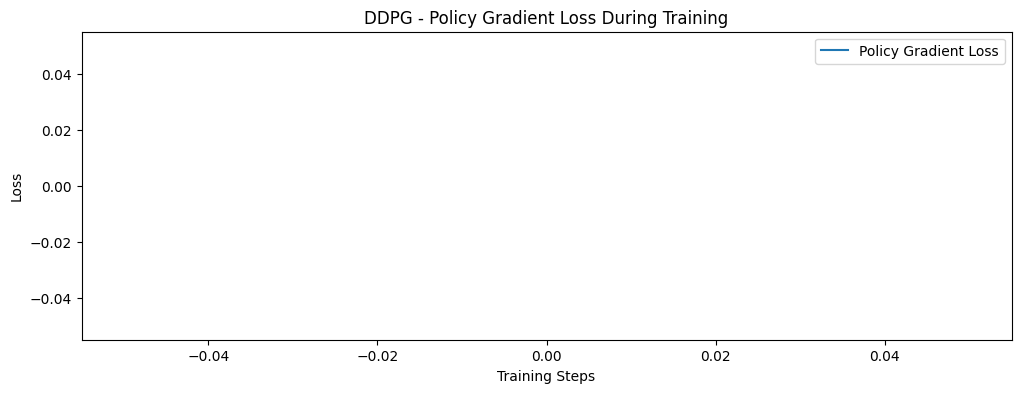

Agent Validation Reward: [163245.88]
Using cpu device
-----------------------------
| time/              |      |
|    fps             | 161  |
|    iterations      | 1    |
|    time_elapsed    | 12   |
|    total_timesteps | 2048 |
-----------------------------
-----------------------------------------
| time/                   |             |
|    fps                  | 151         |
|    iterations           | 2           |
|    time_elapsed         | 26          |
|    total_timesteps      | 4096        |
| train/                  |             |
|    approx_kl            | 0.006362006 |
|    clip_fraction        | 0.0338      |
|    clip_range           | 0.2         |
|    entropy_loss         | -39.7       |
|    explained_variance   | -8.11e-06   |
|    learning_rate        | 0.0003      |
|    loss                 | 5.91e+07    |
|    n_updates            | 10          |
|    policy_gradient_loss | -0.00871    |
|    std                  | 1           |
|    value_loss       

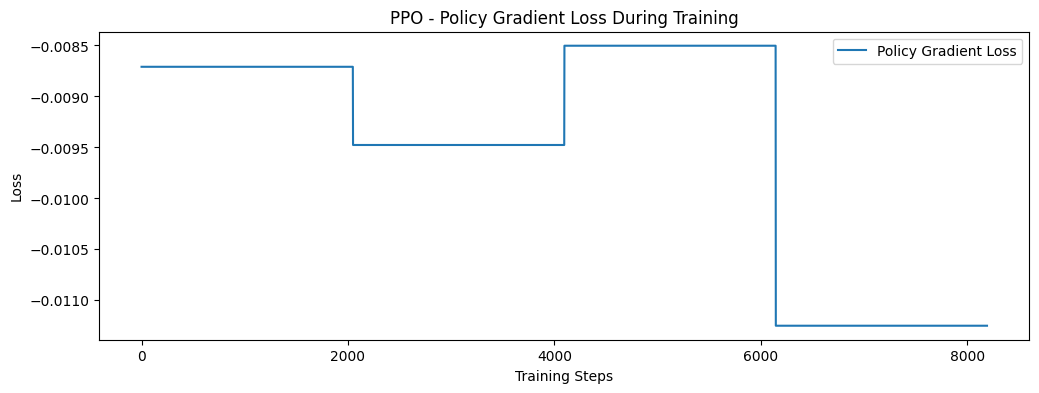

Using cpu device
---------------------------------
| time/              |          |
|    episodes        | 4        |
|    fps             | 20       |
|    time_elapsed    | 340      |
|    total_timesteps | 6968     |
| train/             |          |
|    actor_loss      | 2.23e+06 |
|    critic_loss     | 7.31e+10 |
|    ent_coef        | 7.24     |
|    ent_coef_loss   | -967     |
|    learning_rate   | 0.0003   |
|    n_updates       | 6867     |
---------------------------------


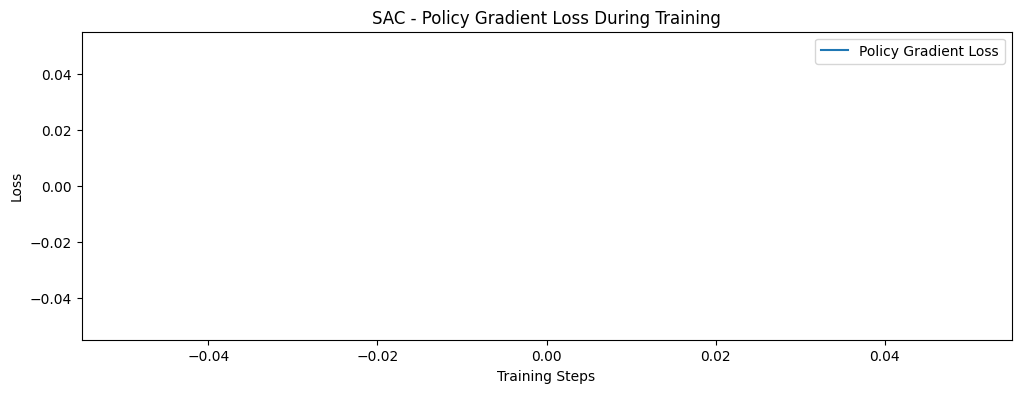

Agent Validation Reward: [144438.2]
Using cpu device
-----------------------------
| time/              |      |
|    fps             | 160  |
|    iterations      | 1    |
|    time_elapsed    | 12   |
|    total_timesteps | 2048 |
-----------------------------
------------------------------------------
| time/                   |              |
|    fps                  | 151          |
|    iterations           | 2            |
|    time_elapsed         | 27           |
|    total_timesteps      | 4096         |
| train/                  |              |
|    approx_kl            | 0.0070169605 |
|    clip_fraction        | 0.0388       |
|    clip_range           | 0.2          |
|    entropy_loss         | -39.7        |
|    explained_variance   | 1.01e-05     |
|    learning_rate        | 0.0003       |
|    loss                 | 5.09e+07     |
|    n_updates            | 10           |
|    policy_gradient_loss | -0.0104      |
|    std                  | 1            |
|    v

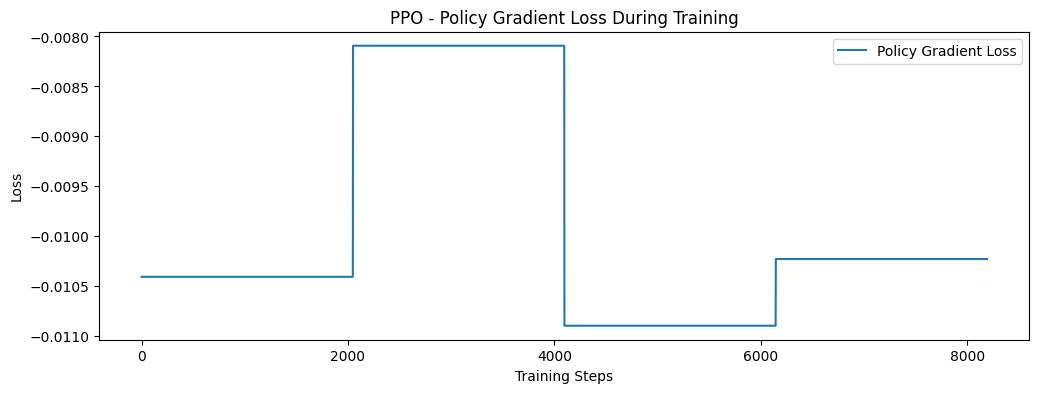

Using cpu device
---------------------------------
| time/              |          |
|    episodes        | 4        |
|    fps             | 20       |
|    time_elapsed    | 342      |
|    total_timesteps | 6968     |
| train/             |          |
|    actor_loss      | 1.92e+06 |
|    critic_loss     | 1.47e+11 |
|    learning_rate   | 0.001    |
|    n_updates       | 6867     |
---------------------------------


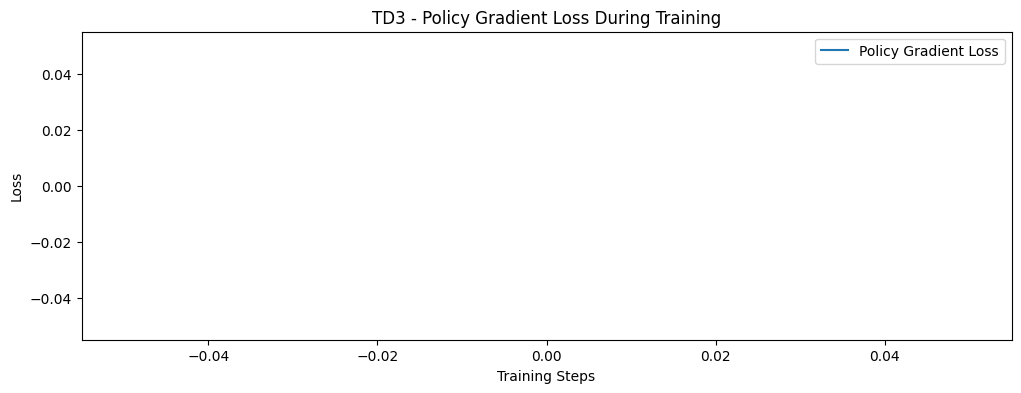

Agent Validation Reward: [282187.78]
Agent Validation Reward: [105721.99]


In [12]:
# Create the environment and train the agents
threshold = 0.1
total_timesteps = 10000
train_env, val_env, ppo_agent, a2c_agent, ddpg_agent, sac_agent, td3_agent, ensemble_agent = \
  create_env_and_train_agents(training_data, validation_data, total_timesteps, threshold)

Testing PPO Agent...


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
/usr/local/lib/python3.10/dist-packages/stable_baselines3/common/vec_env/base_vec_env.py:243: UserWarning: You tried to call render() but no `render_mode` was passed to the env constructor.
  warnings.warn("You tried to call render() but no `render_mode` was passed to the env constructor.")


Testing A2C Agent...
Testing DDPG Agent...
Testing SAC Agent...
Testing TD3 Agent...
Testing Ensemble Agent...


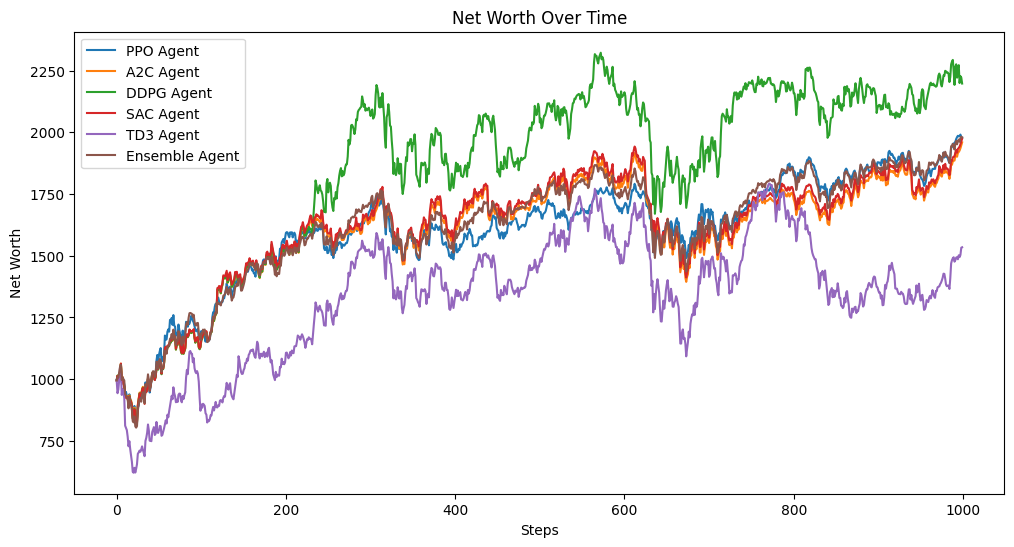

Testing PPO Agent...
Testing A2C Agent...
Testing DDPG Agent...
Testing SAC Agent...
Testing TD3 Agent...
Testing Ensemble Agent...


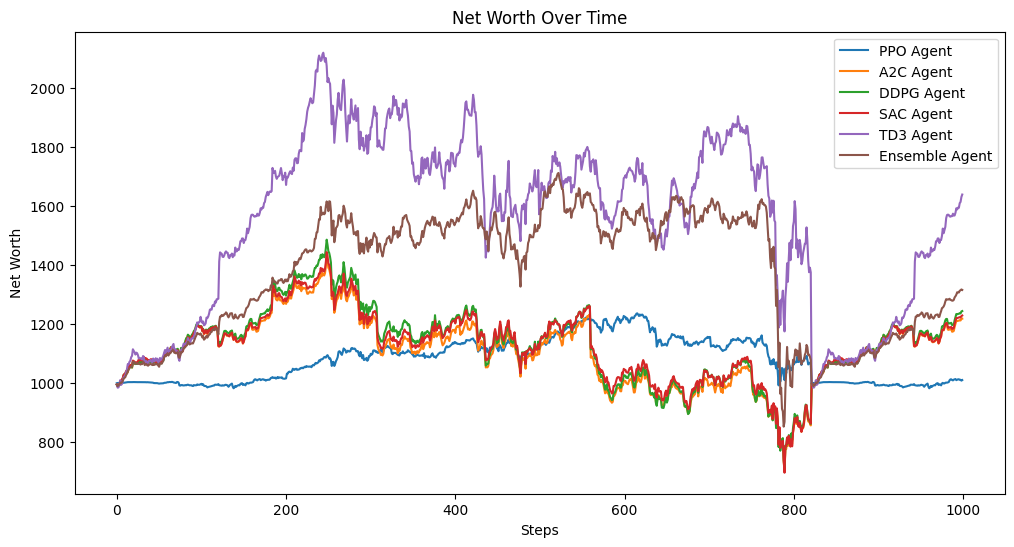

In [13]:
n_tests = 1000
agents = {
    'PPO Agent': ppo_agent,
    'A2C Agent': a2c_agent,
    'DDPG Agent': ddpg_agent,
    'SAC Agent': sac_agent,
    'TD3 Agent': td3_agent,
    'Ensemble Agent': ensemble_agent
}

test_and_visualize_agents(train_env, agents, training_data, n_tests=n_tests)

test_env = DummyVecEnv([lambda: StockTradingEnv(test_data)])
test_and_visualize_agents(test_env, agents, test_data, n_tests=n_tests)

,Agent,Return,Standard Deviation,Sharpe Ratio
4,TD3 Agent,0.000710,0.020072,0.035393
5,Ensemble Agent,0.000398,0.015257,0.026057
2,DDPG Agent,0.000346,0.015637,0.022101
3,SAC Agent,0.000332,0.015535,0.021348
1,A2C Agent,0.000315,0.014991,0.020987
0,PPO Agent,0.000032,0.006527,0.004903


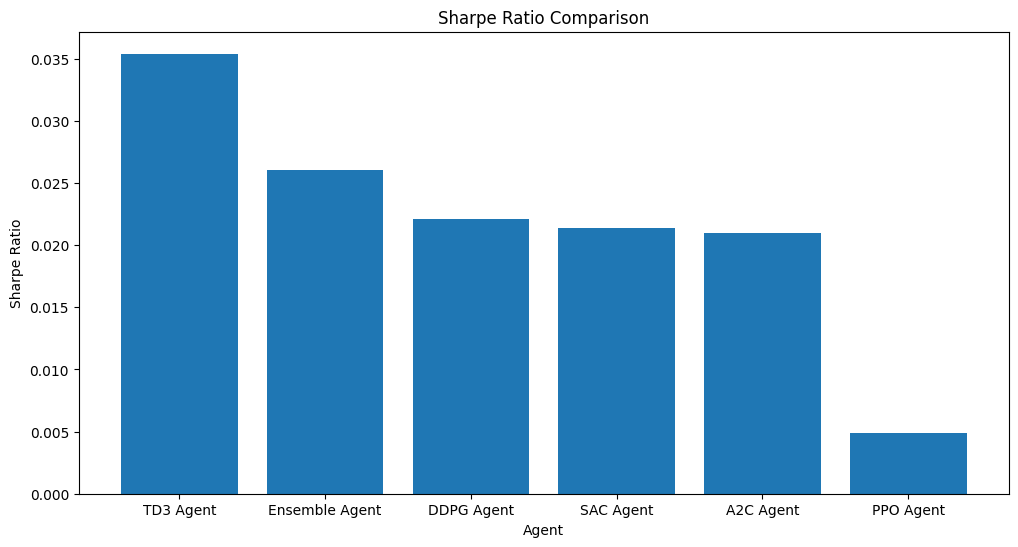

In [14]:
test_agents_metrics = [test_agent(test_env, agent, test_data, n_tests=n_tests, visualize=False) for agent in agents.values()]
compare_and_plot_agents(test_agents_metrics, list(agents.keys()))

In [15]:
def prepare_next_day_data(stock_data):
    """ Prepares the observation for the next trading day """

    # Initialize the environment with the current stock data
    env = StockTradingEnv(stock_data)
    env.reset()

    # Prepare the next day's observation
    next_day_observations = env._next_observation()

    return next_day_observations

# -----------------------------------------------------------------------------

def generate_next_day_recommendations(agents, next_day_observation):
    """ Generate recommendations for the next trading day using the trained agents """

    recommendations = {agent_name: [] for agent_name in agents.keys()}

    for agent_name, agent in agents.items():
        action = agent.predict(next_day_observation)
        recs = agent.action_to_recommendation(action)
        recommendations[agent_name] = zip(recs, action)

    return recommendations

# -----------------------------------------------------------------------------

# Prepare next day's observation
next_day_observation = prepare_next_day_data(test_data)

# Generate recommendations for the next trading day
recommendations = generate_next_day_recommendations(agents, next_day_observation)

# Print or display recommendations
for agent_name, recs in recommendations.items():
  if agent_name == 'Ensemble Agent':
      print(f'\nRecommendations for {agent_name}:')
      for ticker, recommendation in zip(tickers, recs):
          print(f"{ticker}: {recommendation}")


Recommendations for Ensemble Agent:
MMM: ('buy', 0.40688768)
AXP: ('sell', -0.2616292)
AAPL: ('sell', -0.7507094)
BA: ('buy', 0.4922997)
CAT: ('hold', 0.00078818796)
CVX: ('sell', -0.39555034)
CSCO: ('sell', -0.7936787)
KO: ('buy', 0.36565942)
DIS: ('hold', 0.008040786)
GS: ('buy', 0.80356514)
HD: ('buy', 0.5674627)
IBM: ('sell', -0.12562132)
INTC: ('sell', -0.39986423)
JNJ: ('buy', 0.51218814)
JPM: ('buy', 0.33577552)
MCD: ('hold', -0.0027872324)
MRK: ('hold', 0.0808112)
MSFT: ('buy', 0.6516134)
NKE: ('hold', -0.004575777)
PFE: ('sell', -0.40941468)
PG: ('buy', 0.39987013)
TRV: ('buy', 0.4073804)
UNH: ('buy', 0.40515032)
VZ: ('sell', -0.4012224)
V: ('hold', -0.013563442)
WBA: ('sell', -0.23775184)
WMT: ('hold', 0.002071655)
XOM: ('hold', -0.018129969)


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
